## Кластеризация и уменьшение размерности

Ранее мы рассматривали методы обучения с учителем, где для каждого элемента входных данных было задано ожидаемое значение целевой функции. Однако в некоторых случаях можно обойтись без целевой функции, используя некоторые свойства самого датасета. В этом случае говорят об **обучении без учителя**.

Рассмотрим снова датасет изображений рукописных цифр [MNIST](https://ru.wikipedia.org/wiki/MNIST_(%D0%B1%D0%B0%D0%B7%D0%B0_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85)):

In [2]:
import sklearn as sk
import sklearn.model_selection
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

In [3]:

mnist = fetch_openml('mnist_784')

X = mnist.data.to_numpy()/255.0
Y = mnist.target.to_numpy().astype(np.uint8)
print(X.shape, Y.shape)

(70000, 784) (70000,)


Мы можем использовать свойста **близости** изображений цифр, чтобы реализовать алгоритм классификации.

### KNN классификаторы

Алгоритм **k ближайших соседей** (*K nearest neighbors*) используется в том случае, если на множестве есть некоторая метрика близости. Для цифр метрикой близости можно считать, например, среднеквадратичную разность между яркостями всех пикселей изображения:

In [ ]:
def dist(X,Y):
    return np.sum((X-Y)*(X-Y))

for _ in range(15):
    i,j = np.random.randint(0,len(X),size=2)
    print(f"Distance between {Y[i]} and {Y[j]} is {dist(X[i],X[j])}")

Вы можете запустить этот код несколько раз, он считает расстояние между изображениями случайных цифр. Можно заметить, что расстояния между изображениями одних и тех же цифр стабильно меньше.

Исходя из этого, можно предложить следующий алгоритм классификации входного изображения $I$:

1. Ищем такое изображение $X_i$ из нашего обучающего датасета, что $\mathrm{dist}(X_i,I)\to\min$.
2. В качестве ответа возвращаем метку этого изображения $Y_i$.

> Используем для ускорения работы обучающий датасет из 10000 изображений. Вы можете посмотреть, как программа работает на полном датасете, но приготовьтесь ждать

In [ ]:
X_train, X_test, Y_train, Y_test = \
   sk.model_selection.train_test_split(X,Y,train_size=10000, test_size=2000,shuffle=True)

def classify(input_img):
    i = np.argmin([dist(x,input_img) for x in X_train])
    return Y_train[i]

n = 20
correct = 0
for x,y in zip(X_test[:n],Y_test[:n]):
    r = classify(x)
    print(f"{y} classified as {r}")
    correct += (y==r)
print(f"Accuracy: {correct/n}")
    

Нам удалось реализовать классификатор в несколько строчек кода! Это классификатор KNN при K=1.

Для повышения точности можно предложить следующий алгоритм:

1. Выбираем K ближайших по расстоянию цифр к I
2. Из этого множества возвращаем цифру, которая встречается наибольшее число раз

Например, если три ближайшие цифры будут {8,3,3}, то будет возвращено значение 3.

KNN-классификатор также включен в состав библиотеки Scikit Learn:

In [ ]:
import sklearn.neighbors

res=[]
for i in range(1,10):
    model = sk.neighbors.KNeighborsClassifier(n_neighbors=i)
    model.fit(X_train,Y_train)
    acc = sk.metrics.accuracy_score(Y_test,model.predict(X_test))
    print(f"Accuracy for k={i} is {acc}")
    res.append(acc)

Можно заметить, что для некоторого k наблюдается оптимальное значение точности. Поэтому, чтобы получить оптимальную модель для нашего датасета, нужно перебрать несколько значений k. Такая оптимизация называется **оптимизацией гиперпараметров**.

При оптимизации гиперпараметров, чтобы померить "честную" точность модели, нельзя использовать ту же тестовую выборку, что и при оптимизации. Поэтому в таком случае выборку разделяют на три части:
* **Обучающая** используется при обучении моделей
* **Валидационная** используется при оптимизации гиперпараметров
* **Тестовая** используется при финальном тестировании модели

In [ ]:
plt.plot(res)
plt.show()

### Кластеризация. Метод k-средних

В случае с KNN мы решали задачу классификации - хотя и ориентировались в первую очередь на расстояния между объектами в пространстве признаков. Но мы можем поставить и другую задачу - как разбить оптимальным образом все изображения цифр в пространстве признаков на некоторые группы? Это и будет **задача кластеризации**, при этом нам не нужно знать, какие цифры соответствуют изображениям.

Наиболее известный алгоритм кластеризации - это алгоритм **k-средних**. Предположим, мы хотим разбить исходное множество объектов $X$ на $k$ непересекающихся кластеров $X_i$, так, чтобы $\bigcup\limits_i X_i = X$ и $X_i\cap X_j=\emptyset$ для $i\neq j$, и чтобы расстояние между объектами в кластерах было минимальным.

Последнее требование может быть заменено требованием, чтобы суммарное расстояние от всех точек кластера $X_i$ до его **центра масс** $c_i$ было минимальным для всех кластеров, т.е.
\begin{equation}
\sum_{i=1}^k \sum_{x\in S_i} (x-c_i)^2 \to \min
\end{equation}

Алгоритм k-средних является итерационным алгоритмом. Изначально центры масс выбираются случайным образом, после чего на каждом шаге происходит перевычисление центров масс и перегруппировка точек внутри кластеров. Алгоритм завершается, когда на очередной шаг не приводит к изменению кластеров.

Используем K-Means для группировки всех изображений рукописных символов на кластеры:

In [ ]:
import sklearn.cluster

model = sk.cluster.KMeans(n_clusters=10).fit(X)

В процессе кластеризации вычисляются также значения **центроидов** кластеров. Посмотрим на них:

In [ ]:
fig,ax = plt.subplots(1,10)
for i,im in enumerate(model.cluster_centers_):
    ax[i].imshow(im.reshape(28,28))
    ax[i].axis('off')
plt.show()

In [ ]:
model.labels_

Мы видим, что центроиды более-менее соответствуют цифрам, при этом мы сгруппировали похожие символы вместе без какой-либо предварительной разметки. Однако вполне вероятна ситуация, когда какой-то цифре будет соответствовать несколько кластеров, а изображения каких-то двух похожих цифр попадут в один кластер. Это происходит из-за того, что метод k-средних не гарантирует нам получения **глобального минимума** расстояния в формуле (1), а только достижения **локального минимума**.

Для интереса, посмотрим на содержимое одного из кластеров (можете установить значение переменной `c` в соответствии с номером кластера, который хочется исследовать):

In [ ]:
c = 1
res = [ x for x,l in zip(X,model.labels_) if l==c]

fig,ax = plt.subplots(1,20,figsize=(20,5))
for i,im in enumerate(res[:20]):
    ax[i].imshow(im.reshape(28,28))
    ax[i].axis('off')
plt.show()

Чтобы понять подробнее, как работает код выше, посмотрим на значение метода `labels_`:

In [ ]:
print(f"Размер вектора: {model.labels_.shape}")
print(model.labels_[:10])

В этом векторе для каждого элемента из исходного множества $X$ содержится номер соответствующего кластера. По сути дела, имея такие метки мы практически решили задачу классификации - надо лишь установить соответствие номера кластера и цифры. И, по всей видимости, подобрать параметры модели кластеризации, чтобы добиться наилучшего разбиения цифр на кластеры.

#### Пример: Olivetti Faces

Посмотрим на более сложный пример - лица. Используем датасет [Olivetti Faces](https://scikit-learn.org/0.19/datasets/olivetti_faces.html), доступный из Scikit Learn:

In [4]:
from sklearn.datasets import fetch_olivetti_faces
faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True)
faces.shape

(400, 4096)

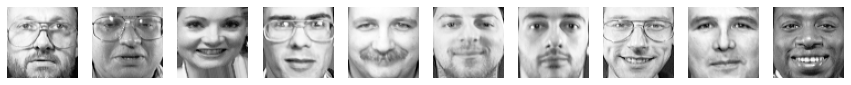

In [5]:
fig,ax = plt.subplots(1,10,figsize=(15,5))
for i in range(10):
    ax[i].imshow(-faces[i].reshape(64,64),cmap='Greys')
    ax[i].axis('off')
plt.show()

Применим алгоритм кластеризации K-means и построим центроиды:

c:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


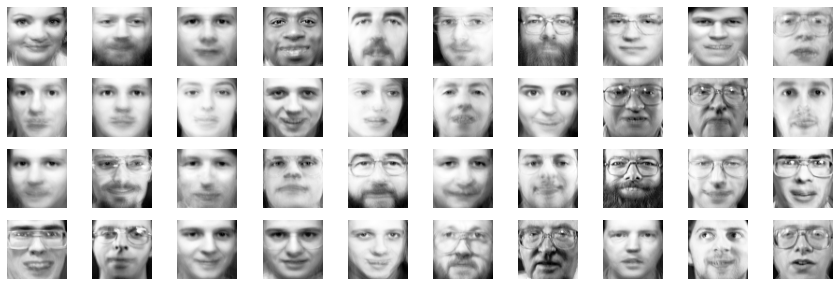

In [9]:
import sklearn.cluster
model = sk.cluster.KMeans(n_clusters=40).fit(faces)

fig,ax = plt.subplots(4,10,figsize=(15,5))
for j in range(4):
    for i in range(10):
        ax[j,i].imshow(-model.cluster_centers_[i+j*10].reshape(64,64),cmap='Greys')
        ax[j,i].axis('off')
plt.show()

Исследуем изображение отдельных классов:

Cluster size=38


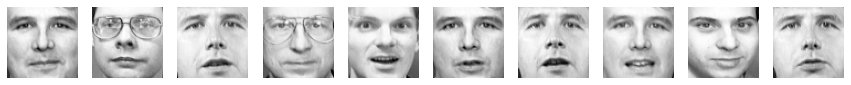

In [17]:
c = 2
res = [ x for x,l in zip(faces,model.labels_) if l==c]

print(f'Cluster size={len(res)}')

fig,ax = plt.subplots(1,min(10,len(res)),figsize=(15,5))
for i,im in enumerate(res[:10]):
    ax[i].imshow(-im.reshape(64,64),cmap='Greys')
    ax[i].axis('off')
plt.show()

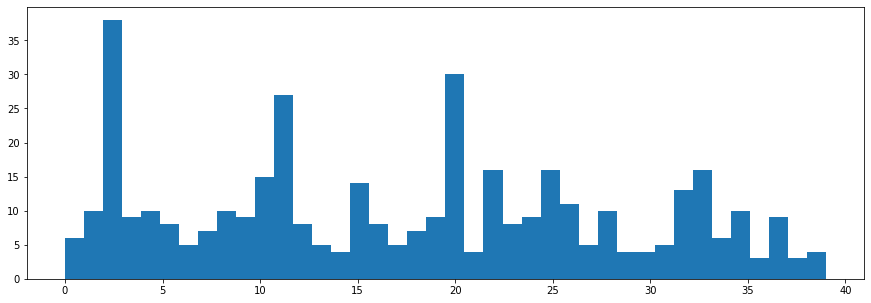

In [16]:
plt.figure(figsize=(15,5))
plt.hist(model.labels_,bins=40)
plt.show()

#### Пример 2: основные цвета на фотографии

Рассмотрим такую фотографию:

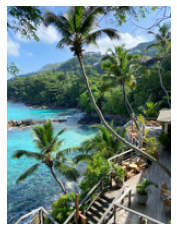

In [18]:
from PIL import Image

img = Image.open("../../../data/datingscout-u7nxI32spEk-unsplash.jpg")
img = img.resize((150,200))
img = np.array(img)/255.0
plt.imshow(img)
plt.axis('off')
plt.show()

Визуально мы видим, что на ней есть много зелёного (пальмы) и голубого (небо, вода) цветов. Если мы хотим повестить фото так, чтобы оно гармонировало с окружающими цветами, то нужно подбирать цвета из соответствующей цветовой гаммы.
Возникает вопрос – как выделить основные цвета фотографии? Если просто усреднить цвета, результат будет не слишком хорош:


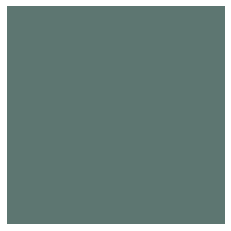

In [34]:
def show_color(c,ax=plt):
    t = np.zeros(shape=(10,10,3))
    t[:] = c
    ax.imshow(t)
    ax.axis('off')
    
show_color(img.mean(axis=(0,1)))

Для выделение индивидуальных цветов можно применить кластеризацию. В этом случае метрикой близости будет естественное евклидово расстояние между RGB-векторами цветов:

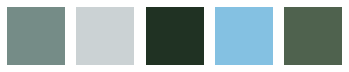

In [37]:
n_clusters = 5

X = img.reshape(-1,3)
km = sk.cluster.KMeans(n_clusters=n_clusters).fit(X)

fig,ax = plt.subplots(1,n_clusters)
for i in range(n_clusters):
    show_color(km.cluster_centers_[i],ax[i])

In [40]:
from tqdm import tqdm

inertias = []
for k in tqdm(range(2,20)):
    km = sk.cluster.KMeans(n_clusters=k).fit(X)
    inertias.append(km.inertia_)

100%|██████████| 18/18 [00:49<00:00,  2.73s/it]


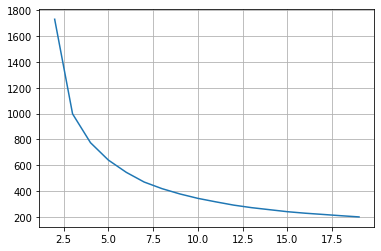

In [42]:
plt.plot(range(2,20),inertias)
plt.grid()

Остаётся вопрос - как в этом случае определить оптимальное число кластеров? Об этом мы поговорим чуть позже.

## Понижение размерности

Метод k-means разбивает наши цифры на кластеры, но при этом наблюдать за этим процессом визуально не представляется возможным, поскольку каждая цифра представляется некоторой точкой в пространстве размерности 784. Для визуального наблюдения за кластеризацией на бы хотелось как-то спроецировать картинку на двумерное пространство.

Такой процесс называется **понижением размерности**. Наиболее известный алгоритм понижения размерности - **[метод главных компонент](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D0%BB%D0%B0%D0%B2%D0%BD%D1%8B%D1%85_%D0%BA%D0%BE%D0%BC%D0%BF%D0%BE%D0%BD%D0%B5%D0%BD%D1%82)** (PCA, *Principal Component Analysis*).

Основная идея метода состоит в следующем. Представим себе некоторое множество точек на плоскости размерности 2. Если мы хотим снизить размерность до 1, то это означает, что мы применяем к исходным точкам некоторое преобразование. Например, мы можем смотреть на эти точки под разными углами, проецируя их на прямую. Для того, чтобы "разглядеть" точки получше, нам нужно выбрать такую проекцию, которая будет максимизировать разброс между точками.

Имея произвольное пространство размерности $n$, мы ищем такое направление (которое называется **главной компонентой**), проекция на которое даёт нам пространство размерности $n-1$, в котором разборос точек максимален. Далее мы повторяем процесс, пока не получим пространство необходимой размерности.

Посмотрим, что даёт метод PCA применительно к нашему датасету:

In [43]:
import sklearn.decomposition

X = mnist.data.to_numpy()/255.0

X2 = sk.decomposition.PCA(n_components=2).fit_transform(X)
X2[:10]

array([[ 0.47943124, -1.24005761],
       [ 3.96271722, -1.13688923],
       [-0.23136081,  1.54383892],
       [-3.12535796, -2.38205539],
       [-1.53457695,  2.86211358],
       [ 0.72930033,  0.87811949],
       [-2.86465293, -0.63561476],
       [ 1.97445451, -1.21073985],
       [-3.42961617, -0.33078367],
       [-1.19222304,  1.81780863]])

Мы получили набор векторов размерности 2, соответствующих нашим исходным рукописным цифрам. Поскольку мы знаем принадлежность цифр различным классам, можем построить эти точки на плоскости и посмотреть, насколько действительно одинаковые цифры оказалиcь близко после PCA-преобразования:

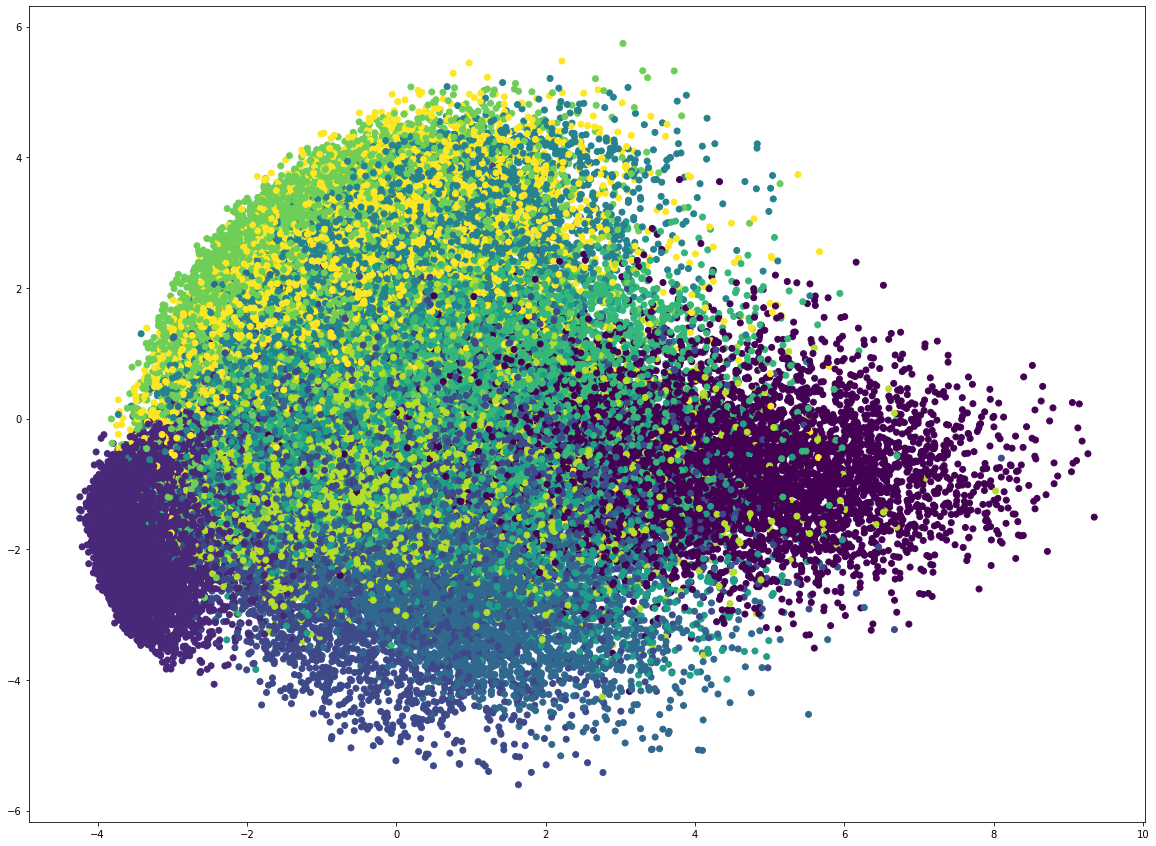

In [45]:
plt.figure(figsize=(20,15))
plt.scatter(X2[:,0],X2[:,1],c=Y)
plt.show()

В целом видно, что одинаковые классы оказываются сгруппированы в похожие кластеры, но при этом есть похожие и непохожие цифры. Посмотрим, как выглядит этот график для цифр 0 и 1:

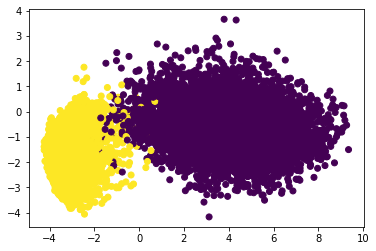

In [46]:
def plot_subset(s):
    tX = np.array([x for x,c in zip(X2,Y) if c in s])
    col = np.array([c for c in Y if c in s])
    plt.scatter(tX[:,0],tX[:,1],c=col)
    plt.show()

plot_subset({0,1})

Видим, что цифры хорошо различимы. Если бы мы применяли логистическую регрессию для классификации, никаких проблем бы не возникло!

Посмотрим теперь на более "похожие" цифры:

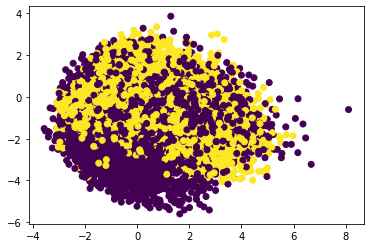

In [47]:
plot_subset({2,5})

Эти цифры уже существенно более "запутаны", и очевидно с их классификацией могут возникнуть проблемы.

Методы снижения размерности оказываются очень полезны для визуализации многомерных данных, чтобы понять, являются ли действительно классы разделимыми. Если мы сталкиваемся с какой-то задачей классификации или кластеризации, можно предварительно провести исследование данных за счет снижения размерности.

## Пример: анализируем страны

В качестве примера исследования данных возьмём [датасет данных по странам](https://www.kaggle.com/datasets/rohan0301/unsupervised-learning-on-country-data), и посмотрим, сможем ли мы сделать какие-то интересные выводы.

In [48]:
import pandas as pd
df = pd.read_csv('../../../data/Country-data.csv')
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


Описание полей из этой таблицы:
* `child_mort` - количество смертей детей до 5 лет, на 1000 чел.
* `exports` - процент валового национального продукта, приходящийся на экспорт
* `health` - процент валового национального продукта, приходящийся на уход за здоровьем
* `imports` - процент валового национального продукта, приходящийся на импорт
* `Income` - доход на душу населения
* `Inflation` - инфляция, рост общего национального продукта год к году
* `life_expec` - средняя продолжительность жизни 
* `total_fer` - количество детей, рожденных в среднем каждой женщиной
* `gdpp` - валовый национальный продукт


In [49]:
df.describe().T[['mean','min','max']]

,mean,min,max
child_mort,38.270060,2.6000,208.00
exports,41.108976,0.1090,200.00
health,6.815689,1.8100,17.90
imports,46.890215,0.0659,174.00
income,17144.688623,609.0000,125000.00
inflation,7.781832,-4.2100,104.00
life_expec,70.555689,32.1000,82.80
total_fer,2.947964,1.1500,7.49
gdpp,12964.155689,231.0000,105000.00


Попробуем применить алгоритм PCA, чтобы понять, есть ли в странах какие-то естественные группировки:

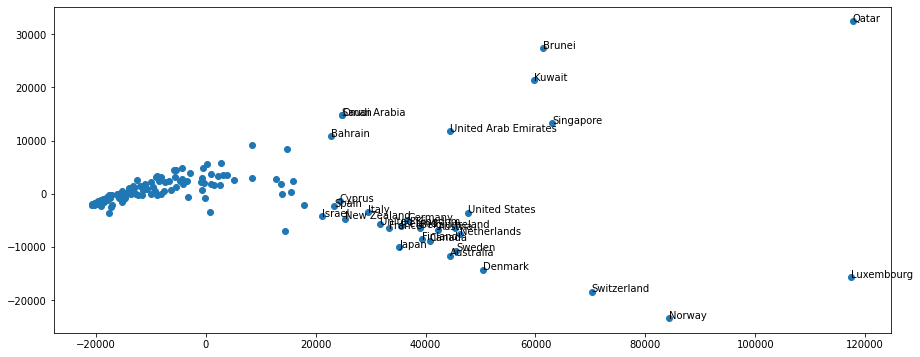

In [54]:
features = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']

names = df['country']
res = sk.decomposition.PCA(n_components=2).fit_transform(df[features])
plt.figure(figsize=(15,6))
plt.scatter(res[:,0],res[:,1])
for n,x,y in zip(names,res[:,0],res[:,1]):
    if x>20000 or y>10000:
        plt.annotate(n,(x,y))
plt.show()

Видно, что некоторые страны сильно выделяются из общего множества. Чтобы понять, какие это страны, мы аннотируем те точки, которые находятся в более-менее свободной части графика.

Учитывая, что мы получили очень большие значение после преобразования, мы можем прийти к заключению, что хорошо бы отмасштабировать все признаки перед тем, как делать преобразование координат. Для этого можем использовать стандартное средство SkLearn:

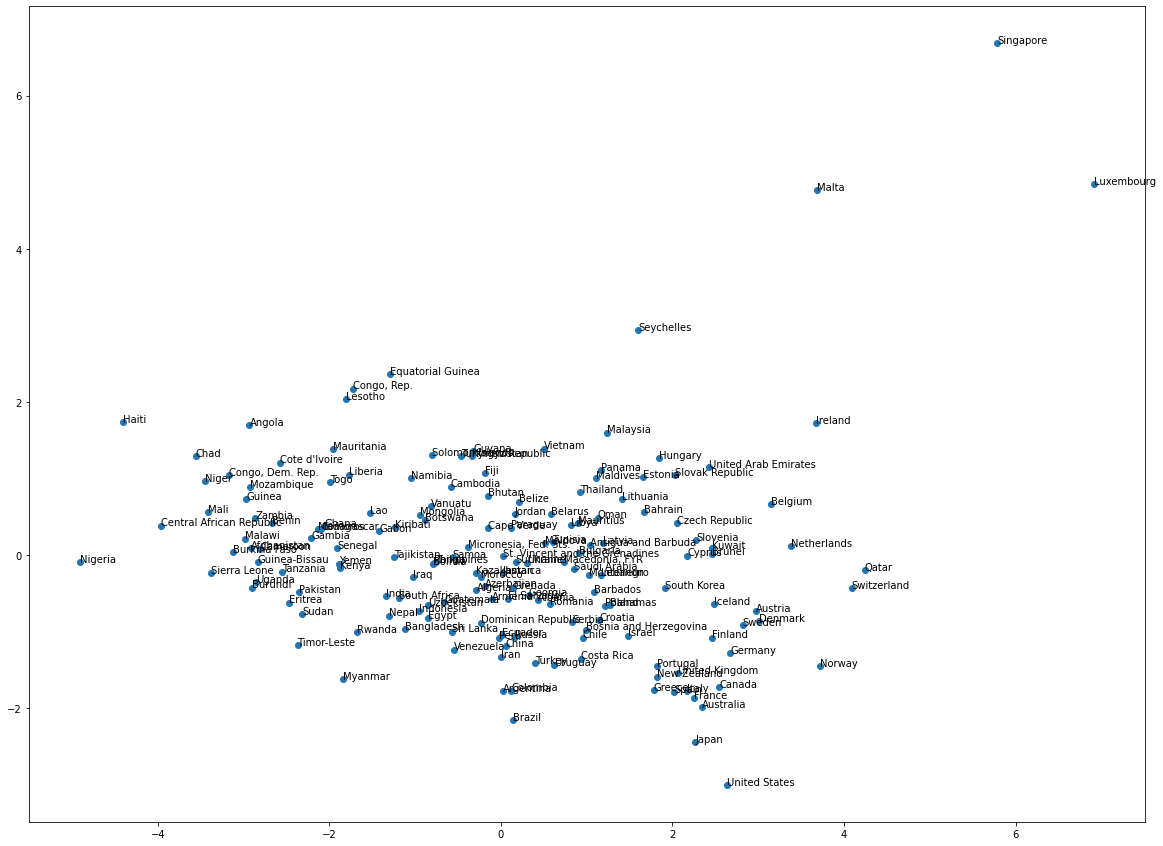

In [55]:
scaler = sk.preprocessing.StandardScaler()
dfs = scaler.fit_transform(df[features])

res = sk.decomposition.PCA(n_components=2).fit_transform(dfs)
plt.figure(figsize=(20,15))
plt.scatter(res[:,0],res[:,1])
for n,x,y in zip(names,res[:,0],res[:,1]):
    if True or y>2.5 or x<-4 or x>3:
        plt.annotate(n,(x,y))
plt.show()

Видим, что равномерность расположения точек стала несколько лучше, и по-прежнему выделаются те же страны (но, возможно, они находятся в другом месте, т.к. PCA не гарантирует каждый раз получение одной и той же системы координат).

Попробуем провести кластеризацию. Однако возникает вопрос - на сколько кластеров разбивать множество стран? Чтобы понять это, обычно делают несколько попыток, и смотрят на параметр **инерции** - это как раз та самая сумма расстояний до центроидов, которую мы видели в уравнении (1):

c:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chun

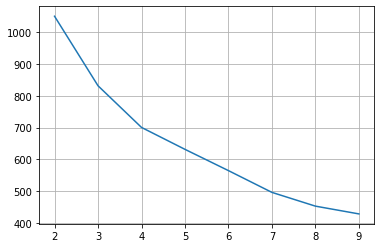

In [56]:
inertias = []
for k in range(2,10):
    km = sk.cluster.KMeans(n_clusters=k).fit(dfs)
    inertias.append(km.inertia_)

plt.plot(range(2,10),inertias)
plt.grid()

Часто бывает так, что после какого-то значения k наступает перелом в графике, после которого инерция уже не сильно снижается. В этом случае такое значение как раз можно считать оптимальным. В нашем случае можно выбрать значение 4 или 5:

In [67]:
nclusters = 7
km = sk.cluster.KMeans(n_clusters=nclusters).fit(dfs)
km.labels_

c:\winapp\conda\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


array([0, 2, 5, 0, 2, 5, 5, 1, 1, 5, 2, 4, 5, 2, 2, 1, 2, 0, 2, 5, 2, 5,
       5, 4, 2, 0, 0, 2, 0, 1, 2, 0, 0, 2, 5, 5, 0, 0, 0, 2, 0, 2, 2, 2,
       1, 5, 5, 5, 2, 0, 0, 2, 2, 1, 1, 5, 0, 2, 1, 0, 1, 2, 5, 0, 0, 2,
       0, 2, 1, 5, 5, 5, 5, 1, 1, 1, 5, 1, 2, 5, 0, 0, 4, 2, 5, 2, 2, 0,
       0, 2, 2, 3, 2, 0, 0, 2, 2, 0, 3, 0, 2, 2, 2, 5, 2, 5, 0, 5, 0, 5,
       1, 1, 0, 6, 1, 4, 0, 2, 2, 5, 5, 2, 1, 4, 2, 5, 0, 5, 4, 0, 2, 2,
       0, 3, 2, 2, 2, 5, 2, 1, 5, 2, 0, 2, 1, 1, 5, 0, 2, 0, 0, 5, 2, 5,
       5, 0, 2, 4, 1, 1, 5, 5, 5, 5, 2, 5, 0])

In [68]:
pd.DataFrame(scaler.inverse_transform(km.cluster_centers_),columns=features)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,97.430000,27.752750,6.409750,43.910000,2957.075000,9.491375,58.712500,5.190250,1467.300000
1,4.295652,40.730435,10.513478,38.247826,40265.217391,1.334913,80.891304,1.810870,45417.391304
2,15.465385,49.963462,7.065769,59.836538,14398.653846,4.061115,73.903846,2.020192,8649.346154
3,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667
4,10.700000,65.557143,3.281429,38.700000,67171.428571,12.517143,76.928571,2.287143,34057.142857
5,33.502439,29.463146,5.467805,32.311363,9819.512195,11.683073,70.426829,2.731951,4842.097561
6,130.000000,25.300000,5.070000,17.400000,5150.000000,104.000000,60.500000,5.840000,2330.000000


Найдем типичных представителей каждого из кластеров. Координаты центроидов не соответствуют конкретным точкам из датасета (странам), поэтому нам надо найти ближайшие к ним точки:

In [69]:
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, dfs)
names[closest]

106    Mozambique
58        Germany
24       Bulgaria
133     Singapore
82         Kuwait
47          Egypt
113       Nigeria
Name: country, dtype: object

Чтобы проделать дальнейший анализ данных, мы можем добавить информацию о кластере в исходный датафрейм:

In [70]:
df['cluster'] = km.labels_
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,5
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,5
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,5
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,2
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,5


Посмотрим на средние значения параметров по кластерам:

In [71]:
d = { x : 'mean' for x in features }
d['country'] = ', '.join

res = df.groupby('cluster').agg(d)
res

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,country
cluster,,,,,,,,,,
0,97.430000,27.752750,6.409750,43.910000,2957.075000,9.491375,58.712500,5.190250,1467.300000,"Afghanistan, Angola, Benin, Burkina Faso, Buru..."
1,4.295652,40.730435,10.513478,38.247826,40265.217391,1.334913,80.891304,1.810870,45417.391304,"Australia, Austria, Belgium, Canada, Denmark, ..."
2,15.465385,49.963462,7.065769,59.836538,14398.653846,4.061115,73.903846,2.020192,8649.346154,"Albania, Antigua and Barbuda, Bahamas, Barbado..."
3,4.133333,176.000000,6.793333,156.666667,64033.333333,2.468000,81.433333,1.380000,57566.666667,"Luxembourg, Malta, Singapore"
4,10.700000,65.557143,3.281429,38.700000,67171.428571,12.517143,76.928571,2.287143,34057.142857,"Bahrain, Brunei, Kuwait, Oman, Qatar, Saudi Ar..."
5,33.502439,29.463146,5.467805,32.311363,9819.512195,11.683073,70.426829,2.731951,4842.097561,"Algeria, Argentina, Armenia, Azerbaijan, Bangl..."
6,130.000000,25.300000,5.070000,17.400000,5150.000000,104.000000,60.500000,5.840000,2330.000000,Nigeria


Можем посмотреть на интересные закономерности: например, как зависит продолжительность жизни от процента расходов на здоровье:

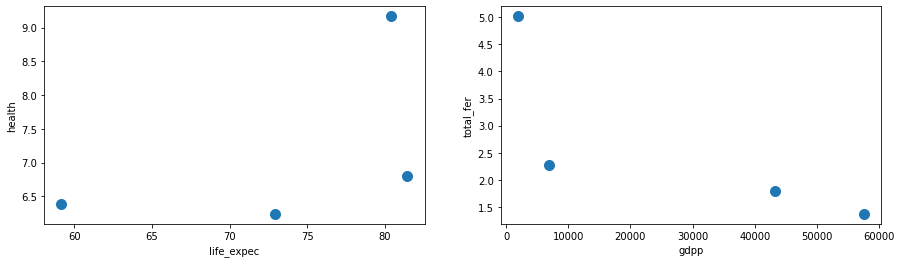

In [65]:
fig,ax = plt.subplots(1,2,figsize=(15,4)) 
res.plot.scatter('life_expec','health',s=100,ax=ax[0])
res.plot.scatter('gdpp','total_fer',s=100,ax=ax[1])
plt.show()

В заключение посмотрим на все группы стран:

In [72]:
for c,all in zip(res.index,res['country']):
    print(f"== Cluster: {c} ==\n{all}")

== Cluster: 0 ==
Afghanistan, Angola, Benin, Burkina Faso, Burundi, Cameroon, Central African Republic, Chad, Comoros, Congo, Dem. Rep., Congo, Rep., Cote d'Ivoire, Equatorial Guinea, Eritrea, Gambia, Ghana, Guinea, Guinea-Bissau, Haiti, Kenya, Kiribati, Lesotho, Liberia, Madagascar, Malawi, Mali, Mauritania, Mozambique, Namibia, Niger, Pakistan, Rwanda, Senegal, Sierra Leone, Sudan, Tanzania, Timor-Leste, Togo, Uganda, Zambia
== Cluster: 1 ==
Australia, Austria, Belgium, Canada, Denmark, Finland, France, Germany, Greece, Iceland, Ireland, Israel, Italy, Japan, Netherlands, New Zealand, Norway, Portugal, Spain, Sweden, Switzerland, United Kingdom, United States
== Cluster: 2 ==
Albania, Antigua and Barbuda, Bahamas, Barbados, Belarus, Belize, Bhutan, Bosnia and Herzegovina, Bulgaria, Cambodia, Cape Verde, Chile, Costa Rica, Croatia, Cyprus, Czech Republic, El Salvador, Estonia, Fiji, Georgia, Grenada, Guyana, Hungary, Jordan, Kyrgyz Republic, Latvia, Lebanon, Libya, Lithuania, Macedoni

**Упражнение**:
1. Поэкспериментируйте с другим числом кластеров и посмотрите, какие страны получаются
1. Попробуйте кластеризацию без предварительного масштабирования и сравните результаты
1. Попробуете использовать `MinMaxScaler` для масштабирования и сравните результаты
1. Реализуйте масштабирование признаков и кластеризацию в виде единого пайплайна (подсказка - используйте `ColumnTransformer` для масштабирования только числовых фич)